### **Importação das bibliotecas necessárias**

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, concatenate, add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

2021-11-09 23:47:22.161853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### **Leitura e pre-processamentos dos dados**

In [2]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_generator.flow_from_directory(
        '../input/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/train',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

test_generator = ImageDataGenerator(rescale=1.0/255)

validation_generator = test_generator.flow_from_directory(
        '../input/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/val',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

test_generator = test_generator.flow_from_directory(
       '../input/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/test',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

Found 153849 images belonging to 2 classes.
Found 19230 images belonging to 2 classes.
Found 19233 images belonging to 2 classes.


## **Definindo funções de métricas de avaliação do modelo**

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def create_model():
    model_resnet = ResNet50(weights='imagenet',
                        include_top=False, 
                        input_shape=(150, 150, 3))
    
    
    model = Sequential(model_resnet, name='dense2')
    model.add(Flatten(name='flatten2'))
    
    model.add(Dense(4096, activation='relu', name='dense1', kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(Dense(1072, activation='relu', name='dense2'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))   
    model.summary()
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rms = RMSprop(lr=2e-5)
    
    model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['acc',f1_m])
    
    return model

In [5]:
from tensorflow.keras import regularizers

In [6]:
model = create_model()

2021-11-09 23:49:48.643349: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-09 23:49:48.647428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-09 23:49:48.693137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 23:49:48.693759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-09 23:49:48.693813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-09 23:49:48.723883: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 0s 0us/step
Model: "dense2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten2 (Flatten)           (None, 51200)             0         
_________________________________________________________________
dense1 (Dense)               (None, 4096)              209719296 
_________________________________________________________________
dense2 (Dense)               (None, 1072)              4391984   
_________________________________________________________________
dropout (Dropout)            (None, 1072)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1073      
Total params: 237,700,065
Trainable params: 237,646,945
Non-t

In [7]:
history = model.fit(
       train_generator,
       epochs=15, 
       validation_data=test_generator)

2021-11-09 23:49:54.076223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-09 23:49:54.080798: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz


Epoch 1/15


2021-11-09 23:50:07.031407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-09 23:50:07.856543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-09 23:50:07.919360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


2404/2404 [==============================] - 2190s 903ms/step - loss: 334.9194 - acc: 0.6864 - f1_m: 0.7488 - val_loss: 3.1234 - val_acc: 0.7783 - val_f1_m: 0.8379
Epoch 2/15
2404/2404 [==============================] - 1490s 620ms/step - loss: 2.6918 - acc: 0.8182 - f1_m: 0.8556 - val_loss: 2.6586 - val_acc: 0.8453 - val_f1_m: 0.8731
Epoch 3/15
2404/2404 [==============================] - 1482s 616ms/step - loss: 2.5842 - acc: 0.8522 - f1_m: 0.8809 - val_loss: 3.3343 - val_acc: 0.7737 - val_f1_m: 0.8385
Epoch 4/15
2404/2404 [==============================] - 1475s 613ms/step - loss: 2.5177 - acc: 0.8725 - f1_m: 0.8962 - val_loss: 2.8629 - val_acc: 0.8335 - val_f1_m: 0.8740
Epoch 5/15
2404/2404 [==============================] - 1448s 602ms/step - loss: 2.4703 - acc: 0.8903 - f1_m: 0.9108 - val_loss: 3.0924 - val_acc: 0.8177 - val_f1_m: 0.8645
Epoch 6/15
2404/2404 [==============================] - 1441s 599ms/step - loss: 2.4395 - acc: 0.8996 - f1_m: 0.9176 - val_loss: 2.9074 - val_ac

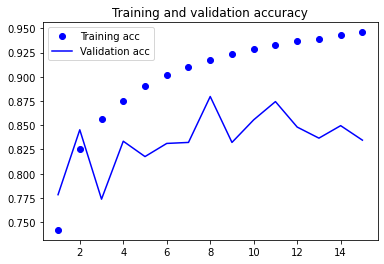

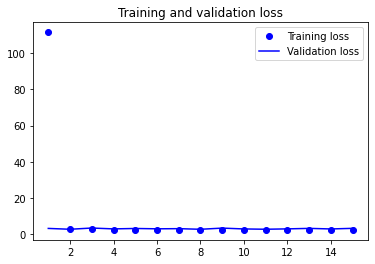

In [8]:
acc = history.history['acc'] 
  
val_acc = history.history['val_acc']  
loss = history.history['loss']
val_loss = history.history['val_loss'];
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')


In [9]:
n_test = 19233
Y_pred = model.predict_generator(test_generator, n_test//64+1)
y_pred = np.argmax(Y_pred, axis=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [11]:
loss, acc, f1_m= model.evaluate_generator(test_generator, 19233)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [12]:
print('Accuracy', acc)
print('f1-score', f1_m)

Accuracy 0.8346071839332581
f1-score 0.8758821487426758
